# Clustering solutions using LDA (Latent Dirichlet Allocation) #

#### Document-term matrix: ####
**758** documents x **1058** terms

![alt text](http://www.speedlab.io/wp-content/uploads/2017/03/DTM.png)


Latent Dirichlet Allocation is a generative model that describes how text documents could be generated probabilistically from a mixture of topics, where each topic has a distribution over words. For each word in a document, a topic is sampled, from which a word is then sampled. This model gives us probabilities of documents, given topic distribution and words. 

![alt text](https://mollermara.com/blog/lda/lda-tikz.png)

There are three levels to the LDA representation:
* $\alpha_{topics}$ and $\alpha_{words}$ are hyperparameters that you set by hand. They show how the Dirichlet distributions create distributions over topics and words, respectively. A Dirichlet distribution outputs a vector that sums to 1, which can be used as the probabilities for a multinomial distribution. The parameters $\alpha_{topics}$ and $\alpha_{words}$ (called respectively $\alpha$ and $\beta$ in the literature) are corpus-level parameters, assumed to be sampled once in the process of generating a corpus. $worddist_k$ is a vector as long as the number of unique words we have in all the documents. For each topic $k$, it tells us how frequently a word is generated under that topic.

* $topicdist_d$ is a vector as long as the number of topics we’re modeling. A vector of length $k$ (the number of topics) is generated for each document $d$, which describes “how much” of each topic is represented in a document. If you think documents are usually only ever 1 topic, you’d probably set $\alpha_{topics}$ really low. If you think documents contain words from a number of topics, you’d probably set $\alpha_{topics}$ slightly higher. In literature these are called $\theta_d$ variables, which are document-level variables, sampled once per document.

* For each word in a document, we draw a topic $wordtopic_{d,w}$ ($z$ in literature) from the output of $topicdist_d$. From the draw topic, we draw a word $Word_{d,w}$ ($w$, in literature).

The estimate the latent distributions (term-topic and topic-document), the most common is to use Gibbs Sampling.


### Import libraries ###

In [229]:
# Input
from db import PythonProblems
import io

# Helpers
import numpy as np
from collections import Counter
from tqdm import tqdm
# import random
import scipy

# Preprocessing
import tokenize
from sklearn.feature_extraction.text import CountVectorizer

# Learning
from sklearn.decomposition import LatentDirichletAllocation
from scipy.cluster import hierarchy
from sklearn.mixture import GaussianMixture

# Evaluation
# from sklearn.metrics import silhouette_samples, silhouette_score
from collections import defaultdict
from scipy.spatial.distance import pdist

# Plots
import matplotlib.pyplot as plt
import seaborn as sns
from bokeh.models import ColumnDataSource, HoverTool, LinearAxis, Range1d
from bokeh.io import show, output_notebook
from bokeh.plotting import figure
import matplotlib.cm as cm
import matplotlib.colors as mpl_colors
import pandas as pd

%matplotlib inline

In [34]:
db = PythonProblems('python.sqlite')

In [35]:
removed_itens = ['NEWLINE', 'STRING', 'ENDMARKER', 'NUMBER', 'INDENT', 'DEDENT', "NL", 'COMMENT', 'ERRORTOKEN']
allowed_itens = ['NAME', 'OP']
cursor = db.conn.cursor()
docs = []
docs_id = []
errors = []

# lendo os dados
cursor.execute("""
SELECT * FROM solution;
""")


for idx, row in enumerate(cursor.fetchall()):
    file = io.StringIO(row[1])
    doc = []
    try:
        for item in tokenize.generate_tokens(file.readline):
            if tokenize.tok_name[item[0]] not in removed_itens:
                if tokenize.tok_name[item[0]] in allowed_itens:
                    doc.append(item[1])
                else:
                    print("%s %s" % (tokenize.tok_name[item[0]], item[1]))
    except (IndentationError, tokenize.TokenError):
        errors.append("Please, fix solution %d before continuing" % (idx+1))
        
    docs.append(' '.join(doc))
    docs_id.append(row[0])

print("Got %d documents" %(idx+1))

if not errors:
    print("Success in parsing all documents! You may go on!")
else:
    for item in errors:
        print(item)

Got 758 documents
Success in parsing all documents! You may go on!


***Limitação do parser: variável e nome reservado são do mesmo tipo. Não consigo separar sem fazer uma pré-lista. Mas pode ser o critério para ajustar o CountVectorizer***

### Preprocessing solutions into bag of words ###

In [36]:
# Initialize the "CountVectorizer" object, which is scikit-learn's
# bag of words tool.  
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = ['print'],   \
                             #max_features = 26d,
                             binary=False,
                             min_df=0.05
                            ) 

# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of 
# strings.

train_data_features = vectorizer.fit_transform(docs)

# Numpy arrays are easy to work with, so convert the result to an 
# array
# Document-term matrix
train_data_features = train_data_features.toarray()
train_data_features.shape

(758, 27)

# Cálculo da LDA #

### Cálculo dos modelos e das métricas *perplexity* e *silhouette*###

In information theory, **perplexity** is a measurement of how well a probability distribution or probability model predicts a sample. It may be used to compare probability models. A low perplexity indicates the probability distribution is good at predicting the sample.

$per(D_{test}) = exp\left \{-\frac{\sum_{d=1}^{M} \log p(w_d)}{\sum_{d=1}^{M} N_d} \right \}$

** PERPLEXITY DO SCIKIT-LEARN PODE ESTAR COM BUGS: [https://github.com/scikit-learn/scikit-learn/issues/6777](https://github.com/scikit-learn/scikit-learn/issues/6777) **

E há algumas controvérsias sobre o uso de Perplexity: [Perplexity To Evaluate Topic Models](http://qpleple.com/perplexity-to-evaluate-topic-models/)

Outras referências sobre Evaluating Topic Models:
1. [Wallach, Hanna M., et al. "Evaluation methods for topic models." Proceedings of the 26th annual international conference on machine learning. ACM, 2009.](http://dirichlet.net/pdf/wallach09evaluation.pdf)
2. [Evaluation Methods for Topic Models - Presentation](http://people.cs.umass.edu/~wallach/talks/evaluation.pdf)
2. [Stanford Language Modeling](https://web.stanford.edu/class/cs124/lec/languagemodeling.pdf)
3. [Quora - How do you compute perplexity for LDA?](https://www.quora.com/How-do-you-compute-perplexity-for-LDA)
4. [How to calculate perplexity of a holdout with Latent Dirichlet Allocation?](https://stats.stackexchange.com/questions/18167/how-to-calculate-perplexity-of-a-holdout-with-latent-dirichlet-allocation)
5. [Matti Lyra - Evaluating Topic Models](https://www.youtube.com/watch?v=UkmIljRIG_M)

Helper functions to calculate gap

In [275]:
def normalize_per_row(matrix):
    row_sums = matrix.sum(axis=1)
    matrix_norm = matrix / row_sums[:, np.newaxis]
    return matrix_norm

def prepare_ref_dataset(data, nrefs=20):
    """ Prepare reference dataset """
    u, s, vh = np.linalg.svd(data, full_matrices=False)
    data_transf = np.matmul(data, vh)
    
    shape = data_transf.shape
    # Set bounding box
    tops = data_transf.max(axis=0)
    bots = data_transf.min(axis=0)

    # Generate distribution
    rands = scipy.random.random_sample(size=(shape[0],shape[1],nrefs))

    # Set offset for random uniform samples to be inside bounding boxes
    dists = scipy.matrix(scipy.diag(tops-bots))
    for i in range(nrefs):
        rands[:,:,i] = rands[:,:,i]*dists+bots
        rands[:,:,i] = np.matmul(rands[:,:,i], vh.T)
    
    return rands

def calculate_wk(X, clusters):
    """ Calculate nr, dr and wk """
    wk = []
    
    for key in clusters.keys():
        # Calculate Dr for each cluster
        obs_idx = clusters[key]
        nr = len(obs_idx)

        if nr == 0:
            raise TypeError("There are empty clusters.")
        
        # Get pairwise distance
        dist = np.array(1 - cosine_similarity(X[obs_idx])).sum()
        
        # Calculate Wk
        wki = dist/(2*nr)
        wk.append(wki)
    
    return np.array(wk).sum()
    

def calculate_gap(X, refs, k, clustering_function):
    """ Calculate Gap """
#     opt_clustering = kwargs.get('clustering', None)
#     opt_wk = kwargs.get('wk', None)
    
    # Calculate Wk for original data
    model, document_topic, clusters = clustering_function(X, k)
#     try:
    wk = calculate_wk(X, clusters)
#     except TypeError as err:
#         message = "Stopping at k=%d. There are empty clusters on original data." % k
#         print(message)
#         raise TypeError(message)
        
    log_wk = np.log(wk)
#     print("wk %s" % log_wk)

    # Calculate Wk for reference distribution
    wk_refs = []
    b_offset = 0
    for ref in range(refs.shape[2]):
        _, _ , clusters = clustering_function(refs[:,:,ref], k)
        try:
            wk_ref = calculate_wk(refs[:,:,ref], clusters)
        except TypeError as err:
            # Skip bad reference
            b_offset += 1
            continue
        log_wk_ref = np.log(wk_ref)
        wk_refs.append(log_wk_ref)
    wkb = np.array(wk_refs)
    wkb_sum = wkb.sum()
#     print("wkb %s" % wkb)
    wkb_std = wkb.std()
    B = wkb.shape[0] - b_offset
    if not B:
        raise ValueError("Stopping at k=%d. No good reference found.")

    # Calculate Gap
    gap = (1/B*wkb_sum) - log_wk
    error = np.sqrt(wkb_std*(1+(1/B)))

    return model, document_topic, gap, error

def define_k(gaps, error):
    """ Get best k according to the criteria on the Tibshirani paper """
    diff = np.array(gaps) - np.array(error)
    gaps[1:] = gaps[:-1]
    gap_diff = np.array(gaps) > diff
    print(gap_diff)
    k = np.argmax(gap_diff[1:] == True)
    print("k = %d" % (k+2))

#### Functions for each clustering method

In [240]:
def lda(X, k, **kwargs):
    model = LatentDirichletAllocation(n_components=k, max_iter=10, learning_method='batch')
    document_topic = model.fit_transform(X)
#     docs_names = docs_id
    topics = [d for d in range(1, document_topic.shape[1]+1)]
    document_topic_norm = normalize_per_row(document_topic)
    document_topic_df = pd.DataFrame(document_topic_norm, columns=topics)
    data = document_topic_df[document_topic_df > 0.3]
    clusters = {}
    for i in document_topic_df.columns:
        clusters[i] = data[i].dropna().index.tolist()
    return model, document_topic, clusters

def hierarquical(X, k, **kwargs):
    # Create linkage matrix for original data
    model = hierarchy.linkage(X, 'ward')
    document_topic = hierarchy.fcluster(model, k, criterion='maxclust')
    clusters = {}
    for key in set(document_topic):
        clusters[key] = np.where(document_topic == key)[0]
    return model, document_topic, clusters

def gaussian_mixture(X, k, **kwargs):
    model = GaussianMixture(n_components=k).fit(X)
    document_topic = model.predict(X)
    clusters = {}
    for key in set(document_topic):
        clusters[key] = np.where(document_topic == key)[0]
    return model, document_topic, clusters

In [277]:
num_topics = list(range(2, min(train_data_features.shape[1], 100)))
num_topics = list(range(2, 20))

In [278]:
output_notebook()

hover = HoverTool(tooltips=[
    ("Model", "$x{0}"),
    ("Gap", "@gap"),
])


models = {}
x = []
gap = []
gap_error = []

# dist = 1 - cosine_similarity(train_data_features)
# Create reference dataset
refs = prepare_ref_dataset(pos, nrefs=2000)

for k in tqdm(num_topics):
    # Build a Latent Dirichlet Allocation Model
    ### Hyperparameters ###
    # alfa = 1/n_components
    # beta = 1/n_components

    # Calculate gaps and error
    try:
        model, document_topic, gap_k, error_k = calculate_gap(pos, refs, k, gaussian_mixture)
    except ValueError as err:
        print(err)
        break
    
    models[k] = {
        'model': model,
#         'topic_word': model.components_,
        'document_topic': document_topic,
        'gap': gap_k,
        'gap_error': error_k
    }

    x.append(k)
    gap.append(models[k]["gap"])
    gap_error.append(models[k]["gap_error"])

source = {'x': x, 'gap': gap, 'gap_error': gap_error}

# opts = dict(plot_width=900, plot_height=500, min_border=0, title="Gap")
# plot = figure(**opts)
# plot.add_tools(hover)

# # Plot Gap
# l = plot.line(x='x', y='gap', color="#2222aa", line_width=2, source=source)
# c = plot.circle(x='x', y='gap', color="#2222aa", fill_color="white", size=8, source=source)

# h = show(plot, notebook_handle=True)

Loading BokehJS ...


100%|██████████| 18/18 [44:31<00:00, 240.80s/it]


In [279]:
gap

[0.15389572460524814,
 0.36950610895374325,
 -0.0010343138246478034,
 0.16890198568616643,
 -0.14198945035274502,
 -0.78196261480443052,
 -0.031386848099237419,
 0.14006911630333629,
 -0.36862719478175698,
 -0.19002255917857402,
 -0.37107133945064019,
 0.056379996162011281,
 0.19495608033981826,
 -0.46501777063626193,
 -0.63167102483080706,
 0.097151581615921856,
 0.40461039706369695,
 -0.57510758005778051]

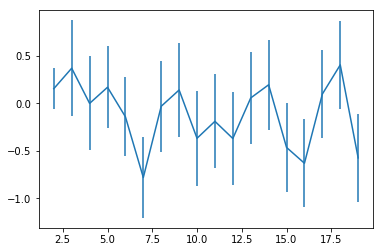

[ True  True  True  True  True  True False  True  True  True  True  True
  True  True  True False  True  True]
k = 2


In [280]:
# Plot data
plt.errorbar(range(2,len(gap)+2), gap, yerr=gap_error)
plt.show()

# Get best k
k = define_k(gap, gap_error)

### Verificando em * random sample solutions* ###

In [7]:
# Escolhido tópico k
k = 8
lda_model = models[k]['model']
document_topic = models[k]['document_topic']
topic_word = models[k]['topic_word']

In [8]:
import pyLDAvis.sklearn
 
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_model, train_data_features, vectorizer, mds='tsne', sort_topics=False)
panel

/home/lmoraes/miniconda3/envs/machine_teaching/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


PreparedData(topic_coordinates=            Freq  cluster  topics           x           y
topic                                                    
0       4.251426        1       1  311.252594 -240.690048
1      10.626874        1       2  167.760300  351.860107
2      11.188737        1       3  382.307404   90.165413
3      17.007363        1       4 -170.606491  347.476044
4       7.584988        1       5    3.236392   -1.636361
5      21.018140        1       6 -298.387512 -248.760269
6      11.930806        1       7 -378.059143   80.120430
7      16.391665        1       8    8.379659 -391.623047, topic_info=     Category        Freq       Term       Total  loglift  logprob
term                                                              
24    Default  222.000000        str  222.000000  27.0000  27.0000
11    Default  241.000000     import  241.000000  26.0000  26.0000
22    Default  331.000000     return  331.000000  25.0000  25.0000
2     Default  363.000000        def  363.000000  24.0000  24.0000
12    Default  525.000000         in  525.000000  23.0000  23.0000
3     Default  230.000000       elif  230.000000  22.0000  22.0000
7     Default  449.000000        for  449.000000  21.0000  21.0000
13    Default  309.000000      input  309.000000  20.0000  20.0000
8     Default  186.000000     format  186.000000  19.0000  19.0000
0     Default  143.000000        and  143.000000  18.0000  18.0000
14    Default  201.000000        int  201.000000  17.0000  17.0000
19    Default   96.000000     random   96.000000  16.0000  16.0000
6     Default   98.000000      float   98.000000  15.0000  15.0000
20    Default  233.000000      range  233.000000  14.0000  14.0000
25    Default  114.000000       true  114.000000  13.0000  13.0000
10    Default  494.000000         if  494.000000  12.0000  12.0000
4     Default  237.000000       else  237.000000  11.0000  11.0000
9     Default   64.000000       from   64.000000  10.0000  10.0000
5     Default   93.000000      false   93.000000   9.0000   9.0000
15    Default   63.000000       join   63.000000   8.0000   8.0000
16    Default  155.000000        len  155.000000   7.0000   7.0000
23    Default   72.000000        set   72.000000   6.0000   6.0000
26    Default  111.000000      while  111.000000   5.0000   5.0000
17    Default   70.000000       list   70.000000   4.0000   4.0000
18    Default   83.000000        not   83.000000   3.0000   3.0000
1     Default  120.000000     append  120.000000   2.0000   2.0000
21    Default   45.000000  raw_input   45.000000   1.0000   1.0000
24     Topic1  221.686218        str  222.552537   3.1540  -0.0281
11     Topic1    1.453701     import  241.890681  -1.9565  -5.0553
9      Topic1    0.351865       from   64.324028  -2.0505  -6.4739
...       ...         ...        ...         ...      ...      ...
22     Topic7    0.127160     return  331.487047  -5.7399  -8.5235
2      Topic7    0.127169        def  363.017727  -5.8306  -8.5235
7      Topic7    0.127180        for  449.856847  -6.0450  -8.5234
22     Topic8  313.968627     return  331.487047   1.7541  -1.0296
2      Topic8  319.695391        def  363.017727   1.6813  -1.0115
26     Topic8   26.294580      while  111.823415   0.3608  -3.5095
16     Topic8   33.659938        len  155.301523   0.2793  -3.2626
10     Topic8  107.181863         if  494.844097   0.2787  -2.1044
4      Topic8   38.836334       else  237.784194  -0.0036  -3.1195
21     Topic8    5.967218  raw_input   45.768017  -0.2289  -4.9926
14     Topic8   24.537086        int  201.964180  -0.2995  -3.5787
13     Topic8    5.542524      input  309.857960  -2.2153  -5.0664
1      Topic8    0.980079     append  120.301689  -3.0017  -6.7990
15     Topic8    0.124786       join   63.238944  -4.4197  -8.8600
9      Topic8    0.124702       from   64.324028  -4.4374  -8.8607
3      Topic8    0.424656       elif  230.590659  -4.4887  -7.6354
17     Topic8    0.124756       list   70.259264  -4.5252  -8.8603
23     Topic8    0.124774  

## Verificando distribuição de documentos por tópico e palavras por tópico

In [9]:
def normalize_per_row(matrix):
    row_sums = matrix.sum(axis=1)
    matrix_norm = matrix / row_sums[:, np.newaxis]
    return matrix_norm

def sort_distribution(df, columns, MIN_PROB=0.3):
    ids = []

    for col in columns:
        ids = ids + df[df[col] > MIN_PROB].sort_values([col], ascending=False).index.tolist()
    
    for col in columns:
        ids = ids + df.sort_values([col], ascending=False).index.tolist()

    index = df.loc[ids].index.drop_duplicates()
    df_sorted = df.loc[index]
    return df_sorted

In [10]:
docs_names = docs_id
topics = ["Topic %d" %d for d in range(1, document_topic.shape[1]+1)]
words = vectorizer.get_feature_names()

In [11]:
document_topic_norm = normalize_per_row(document_topic)
word_topic = topic_word.T
word_topic_norm = normalize_per_row(word_topic)

In [12]:
document_topic_df = pd.DataFrame(document_topic_norm, index=docs_names, columns=topics)
document_topic_df = sort_distribution(document_topic_df, topics, MIN_PROB=0.3)

word_topic_df = pd.DataFrame(word_topic_norm, index=words, columns=topics)
word_topic_df = sort_distribution(word_topic_df, topics, MIN_PROB=0.3)

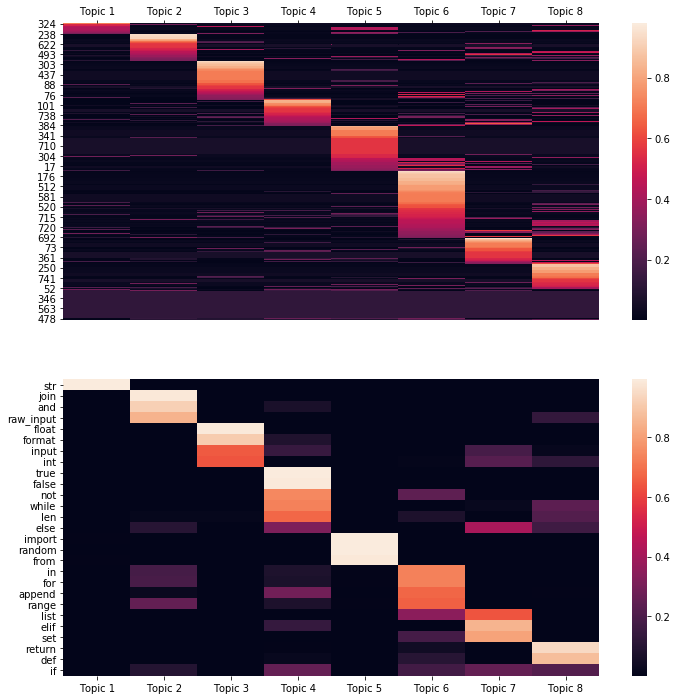

In [13]:
# Create a figure instance, and the two subplots
fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
# fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(12,12))


sns.heatmap(document_topic_df, ax=ax1)
ax1.xaxis.tick_top()
sns.heatmap(word_topic_df, ax=ax2)

plt.show()

### Compare topic distribution with manually labeled categories from the database

In [250]:
sql = "SELECT solution.id, problem.category from solution, problem where solution.problem_id = problem.id"
cursor = db.conn.cursor()
cursor.execute(sql)

rows = cursor.fetchall()
doc_id, doc_category = zip(*rows)

In [15]:
topics_dist = {}

for i in topics:
    df = document_topic_df[document_topic_df[i] > 0.5]
    topics_dist[i] = defaultdict(int)
    for doc in df.index.tolist():
        category = doc_category[doc_id.index(doc)]
        topics_dist[i][category] += 1

In [16]:
topics_df = pd.DataFrame.from_dict(topics_dist)

In [17]:
topics_df

Topic 1  Topic 2  Topic 3  Topic 4  Topic 5  Topic 6  Topic 7  \
NaN              5.0     37.0     45.0       14     55.0     55.0     33.0   
list             1.0      NaN      1.0        8      NaN      8.0     13.0   
string           2.0      5.0     11.0        4      9.0     27.0      7.0   
function         NaN      1.0      NaN        5      NaN      5.0      NaN   
math             NaN      NaN     15.0        1     13.0     15.0      2.0   
loop             NaN      NaN      2.0        5      NaN      2.0      1.0   
conditional      NaN      NaN      2.0        1      NaN      NaN      7.0   
file             NaN      NaN      NaN        2      NaN      2.0      NaN   
dict             NaN      NaN      NaN        3      4.0     17.0      NaN   

             Topic 8  
NaN             35.0  
list             NaN  
string          14.0  
function         7.0  
math             6.0  
loop             NaN  
conditional      NaN  
file             NaN  
dict             2.0

In [18]:
t_purity = []

for k in range(2,k_max+1):
    docs_names = docs_id
    document_topic = models[k]['document_topic']
    topic_word = models[k]['topic_word']
    lda_model = models[k]['model']
        
    topics = ["Topic %d" %d for d in range(1, document_topic.shape[1]+1)]
    words = vectorizer.get_feature_names()
    document_topic_norm = normalize_per_row(document_topic)
    word_topic = topic_word.T
    word_topic_norm = normalize_per_row(word_topic)
    
    
    document_topic_df = pd.DataFrame(document_topic_norm, index=docs_names, columns=topics)
    
    topics_dist = {}

    for i in topics:
        df = document_topic_df[document_topic_df[i] > 0.5]
        topics_dist[i] = defaultdict(int)
        for doc in df.index.tolist():
            category = doc_category[doc_id.index(doc)]
            topics_dist[i][category] += 1
            
    topics_df = pd.DataFrame.from_dict(topics_dist)
    
    topic_df_nan = topics_df.drop([None,'math', 'string'])
    topic_df_nan.plot.pie(figsize=(20,20), subplots=True, layout=(4, 3))
    plt.savefig("lda_topics_%d.png" % k)
    plt.show()
    
    # Calculate purity
    max_value = topic_df_nan.max()
    total_value = topic_df_nan.sum()
    purity = (max_value/total_value).sum()
    t_purity.append(purity)
    print("Purity: %.2f" % purity)

NameError: name 'k_max' is not defined

In [ ]:
topic_df_nan = topics_df.drop([None,'math', 'string'])
topic_df_nan.plot.pie(figsize=(20,20), subplots=True, layout=(4, 3))
plt.show()

### Utilizando clusterização hierárquica

In [ ]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    font_size = kwargs.pop('font_size', 14)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = hierarchy.dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center', fontsize=font_size)
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

In [149]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(train_data_features)

In [8]:
np.savetxt("upper_matrix.csv", dist, delimiter=",")

In [5]:
np.savetxt("points.csv", train_data_features, delimiter=",")

In [ ]:
# Z = hierarchy.linkage(dist, 'ward')
Z = ward(dist)
zdf = pd.DataFrame(Z)
distances = zdf[2].tolist()
distances.sort(reverse=True)

In [19]:
num_topics

[2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26]

In [ ]:
topics_df

Using max_d = 116.65


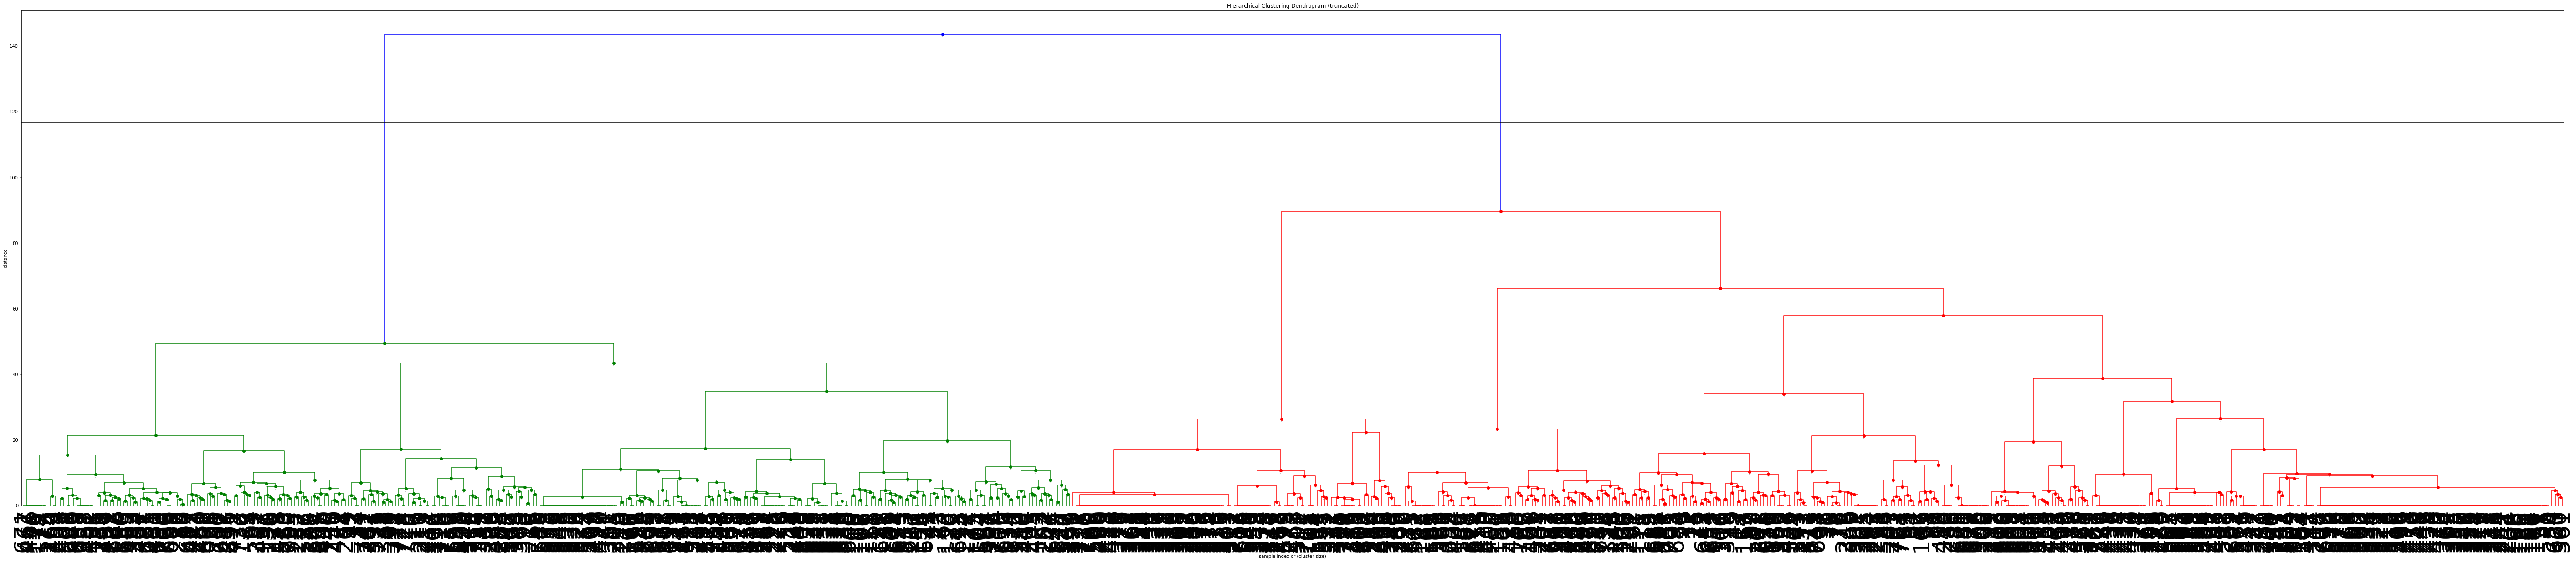

Found errors []
Purity: 0.81


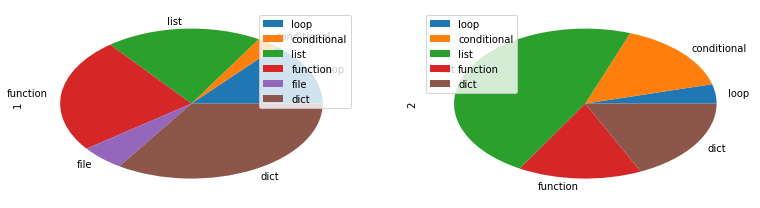

Using max_d = 77.91


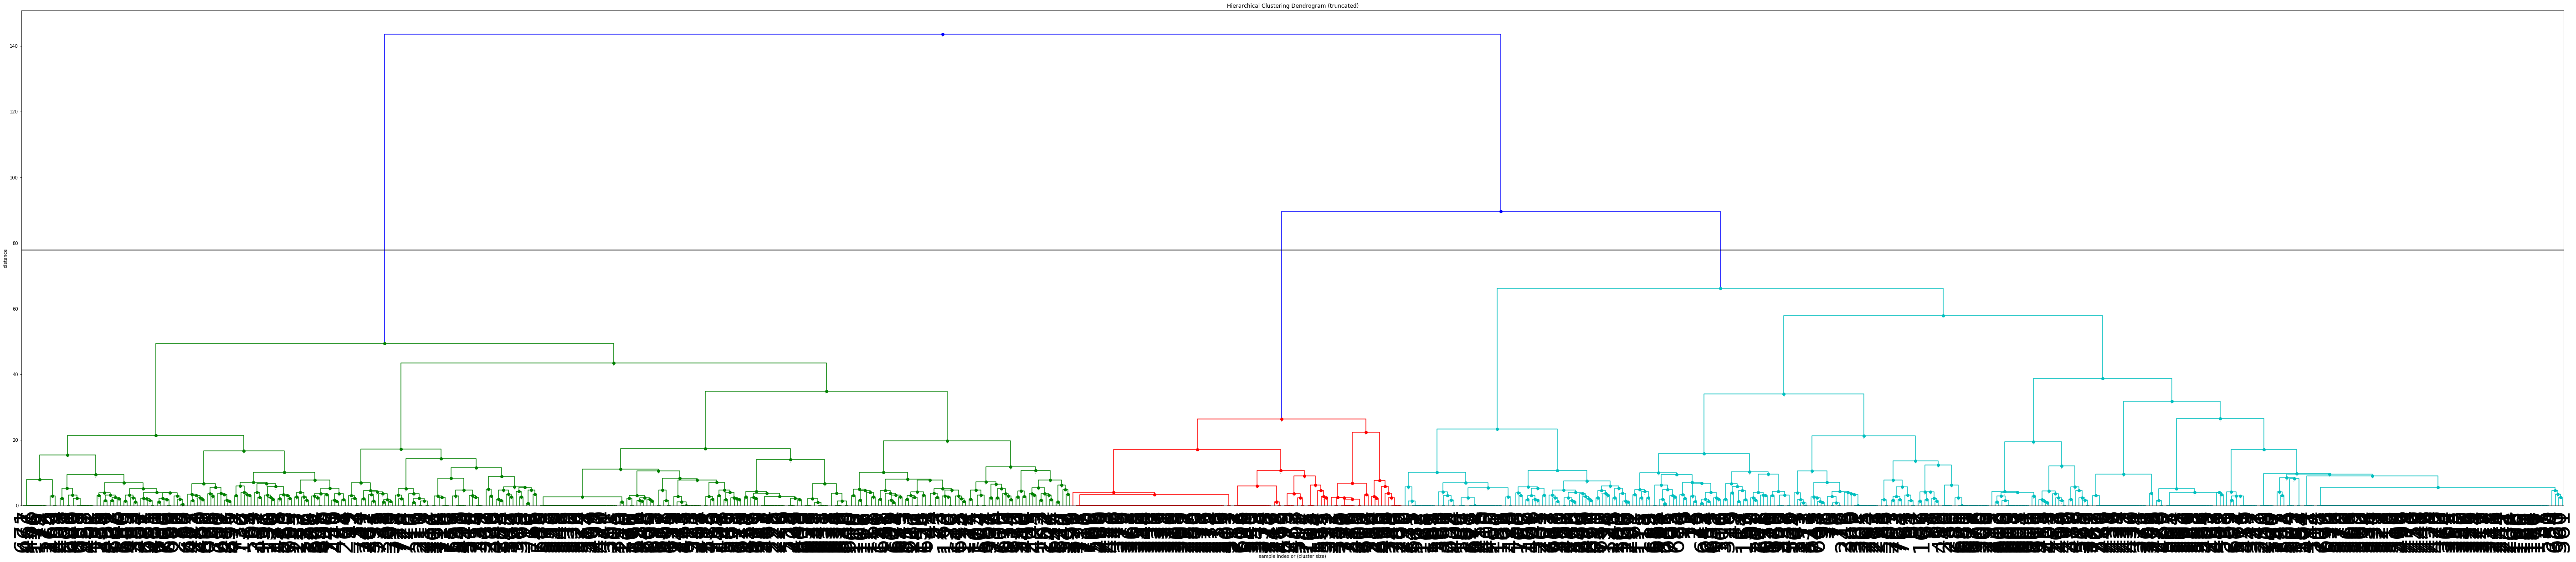

Found errors []
Purity: 1.51


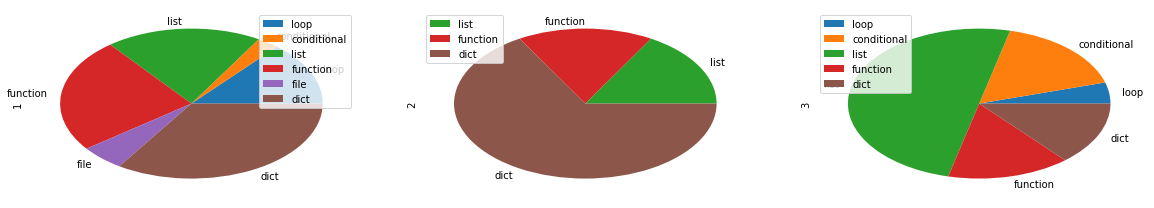

Using max_d = 62.03


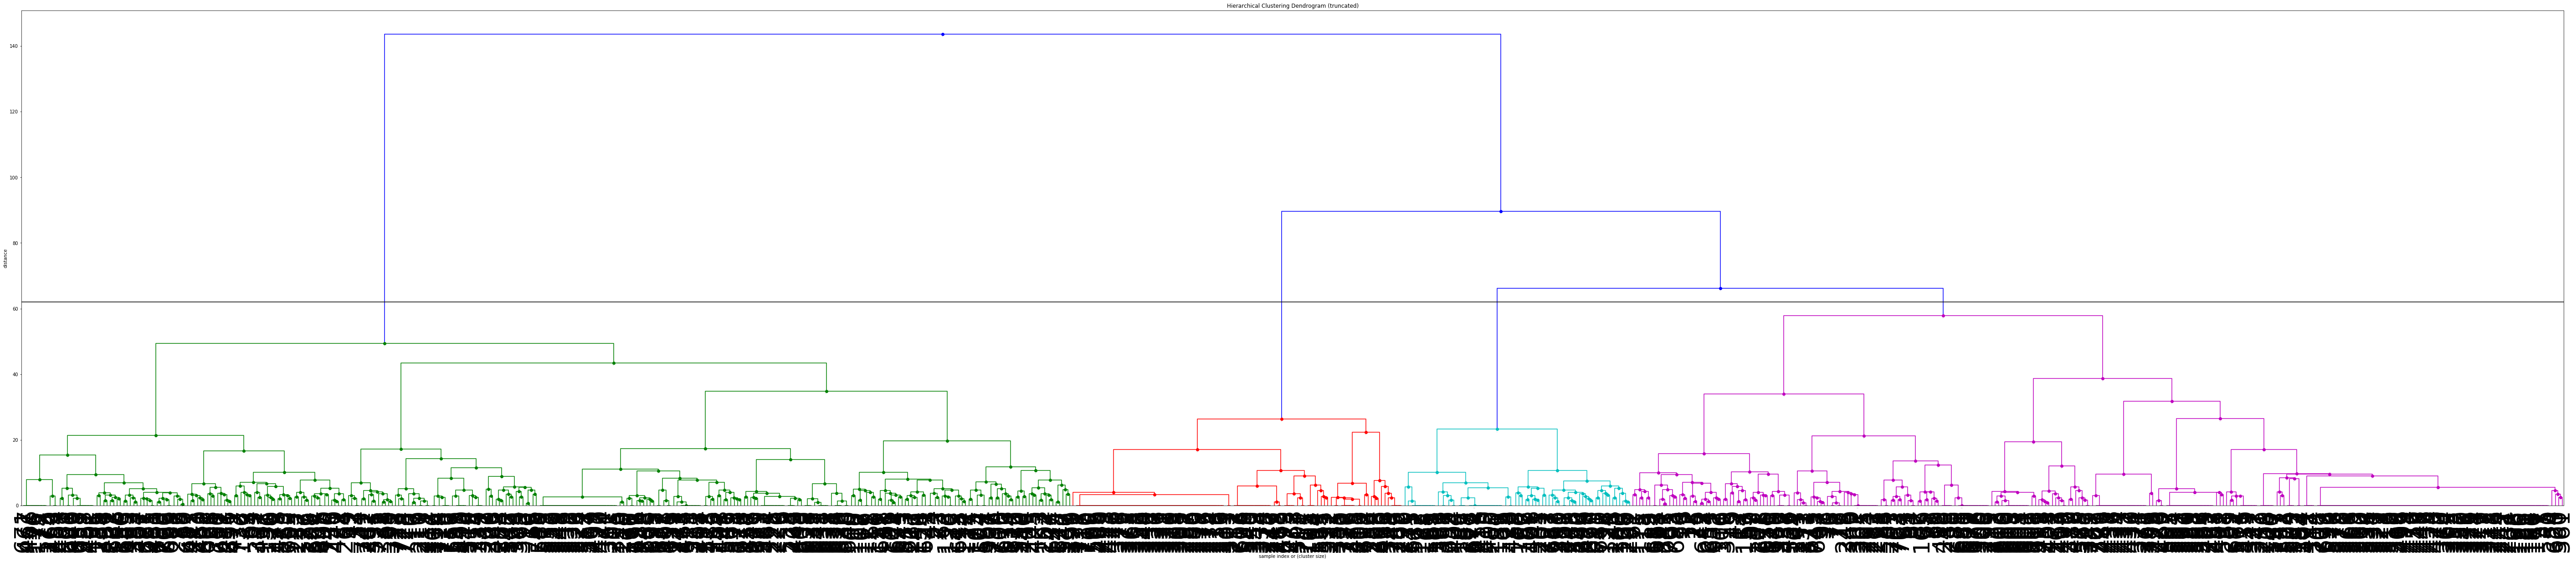

Found errors []
Purity: 2.50


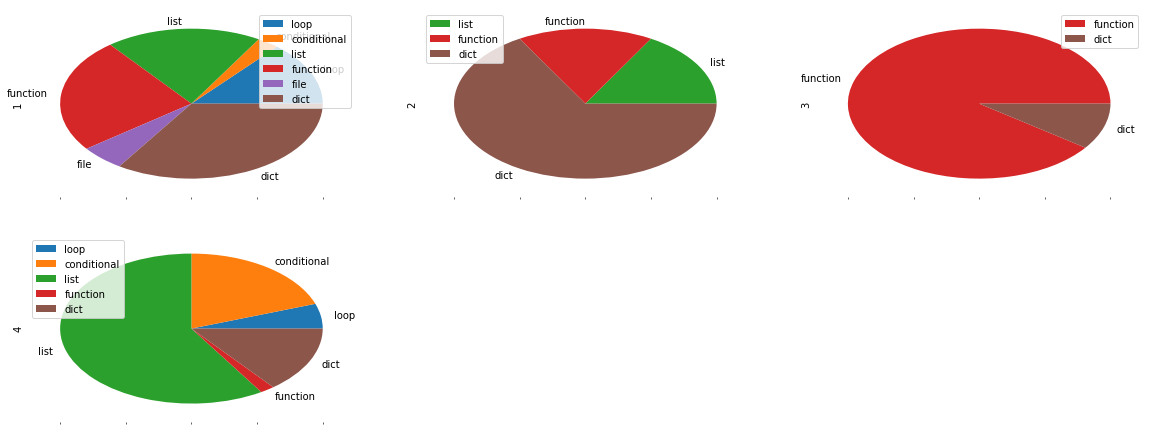

Using max_d = 53.67


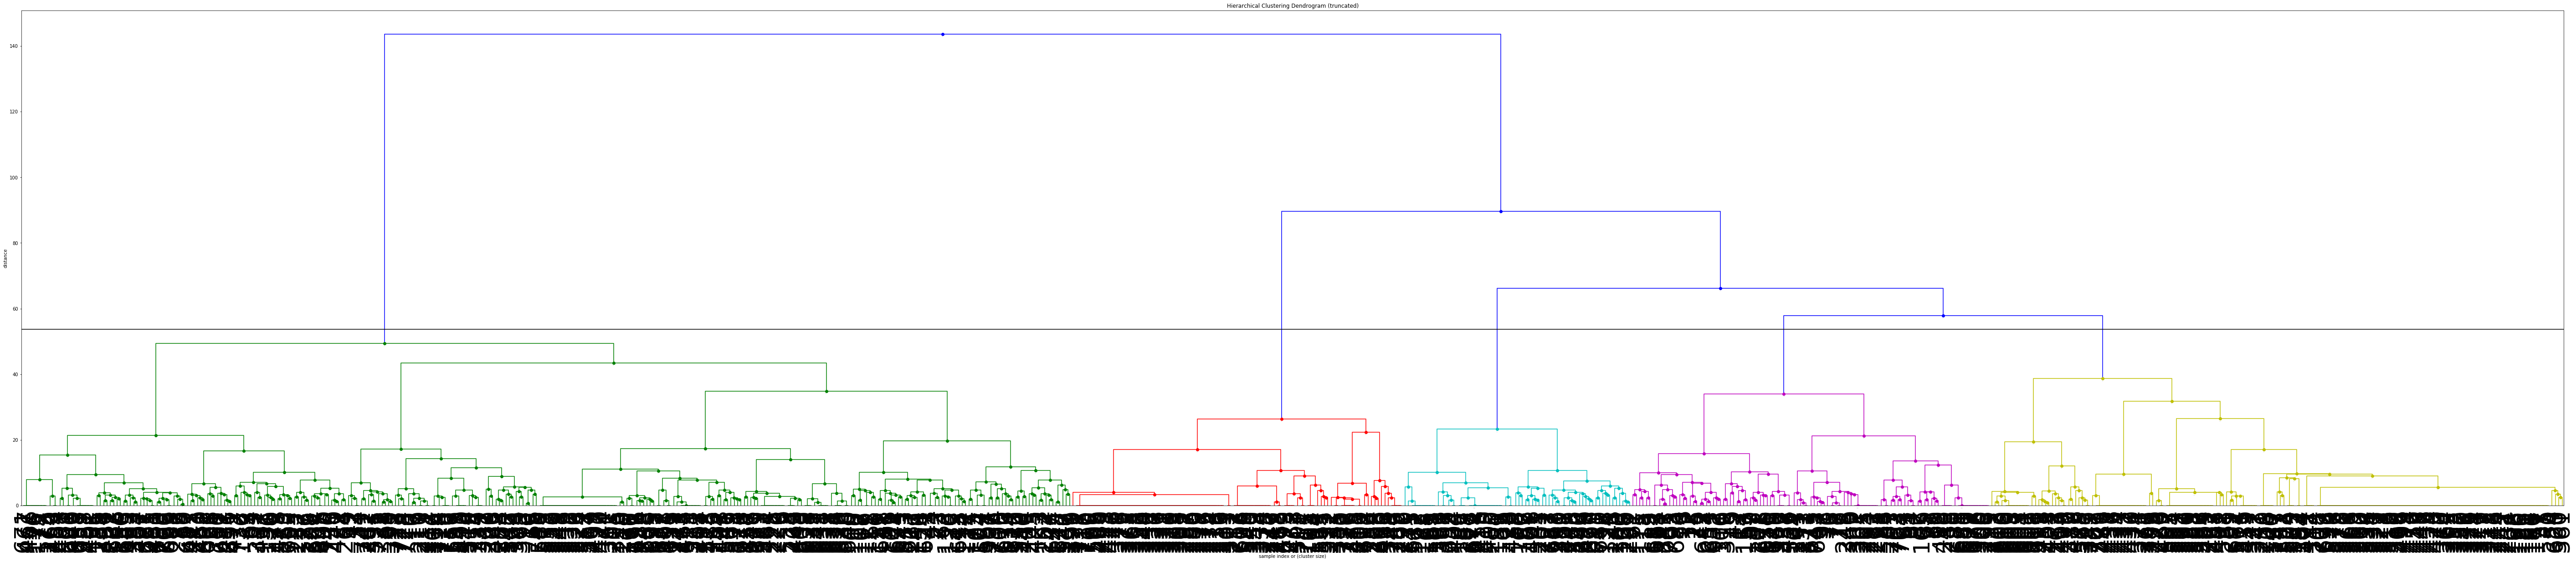

Found errors []
Purity: 3.35


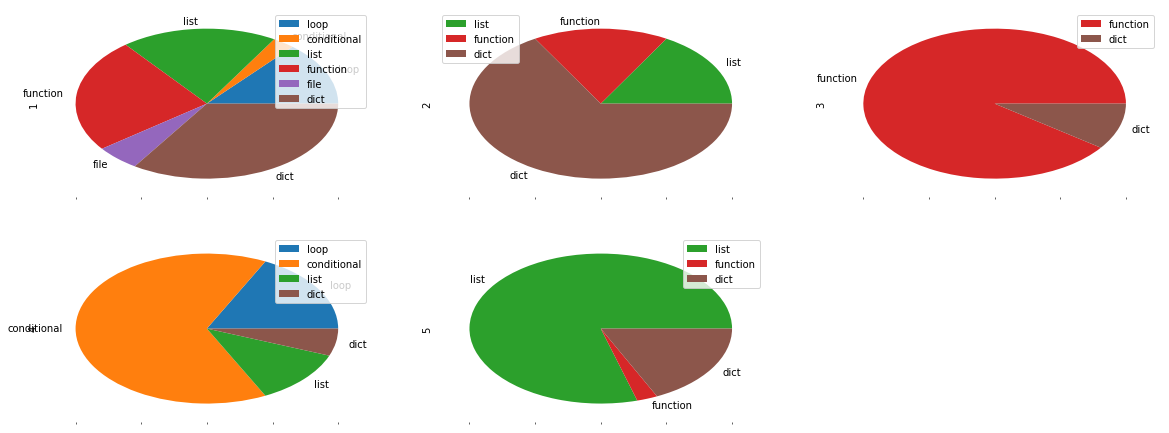

Using max_d = 46.45


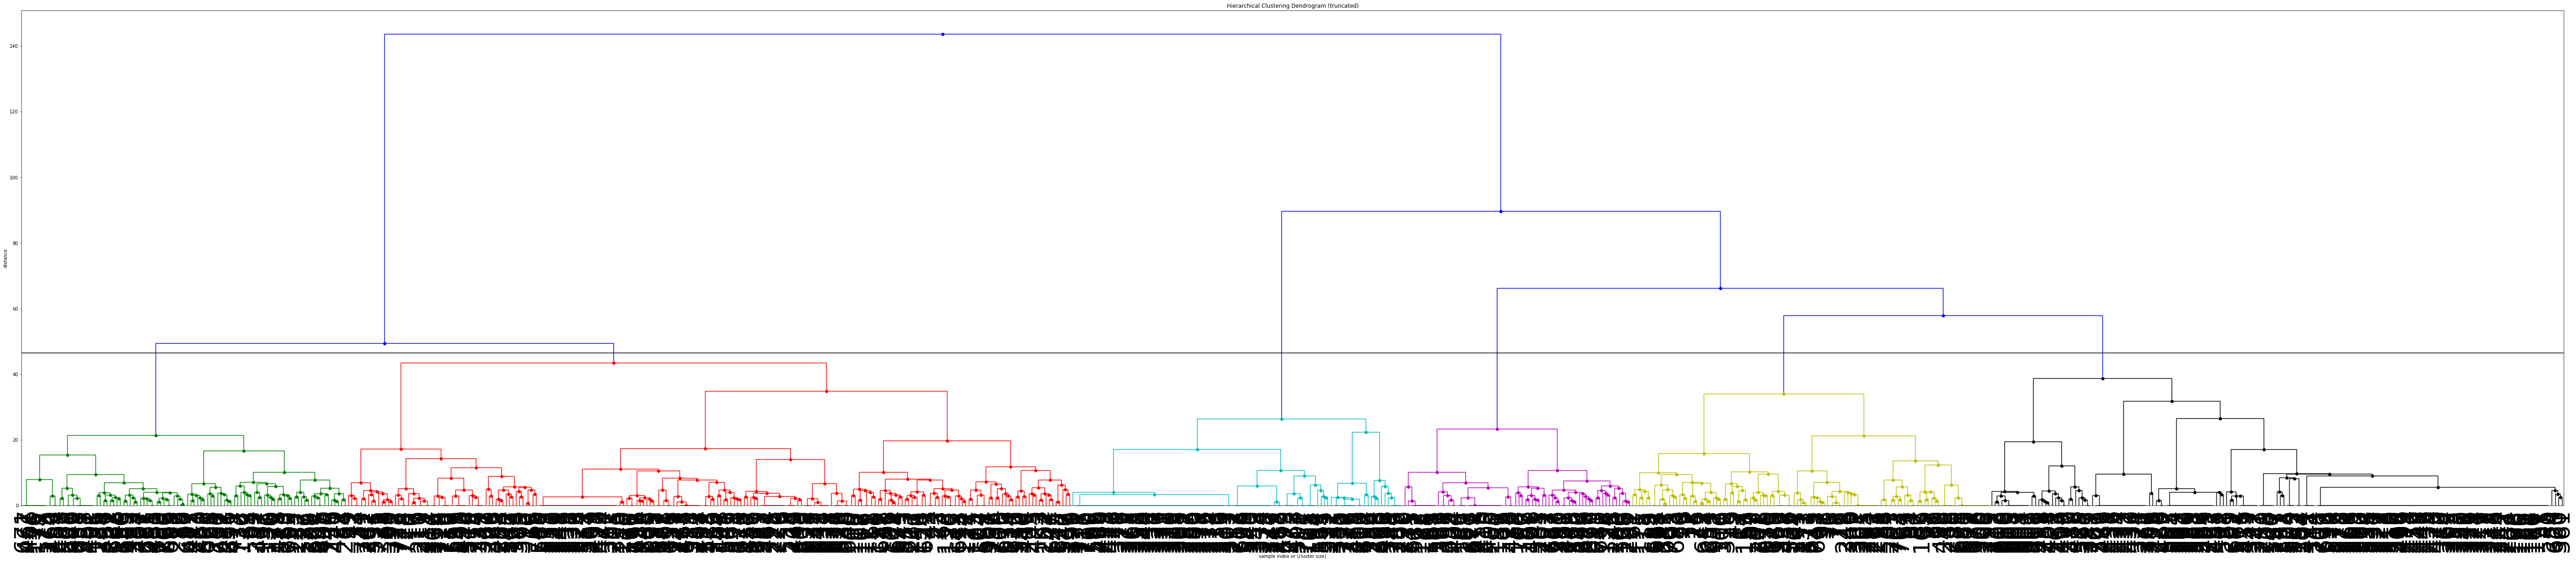

Found errors []
Purity: 4.28


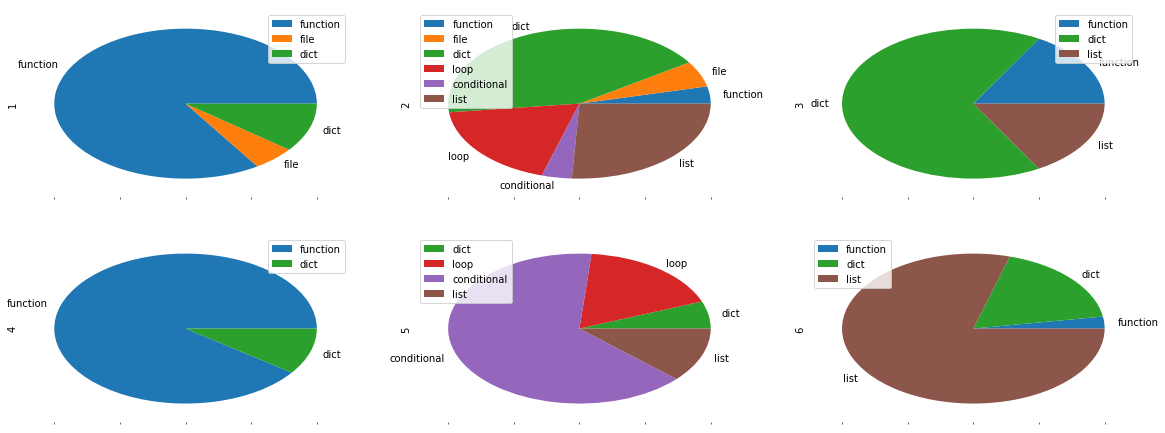

Using max_d = 41.11


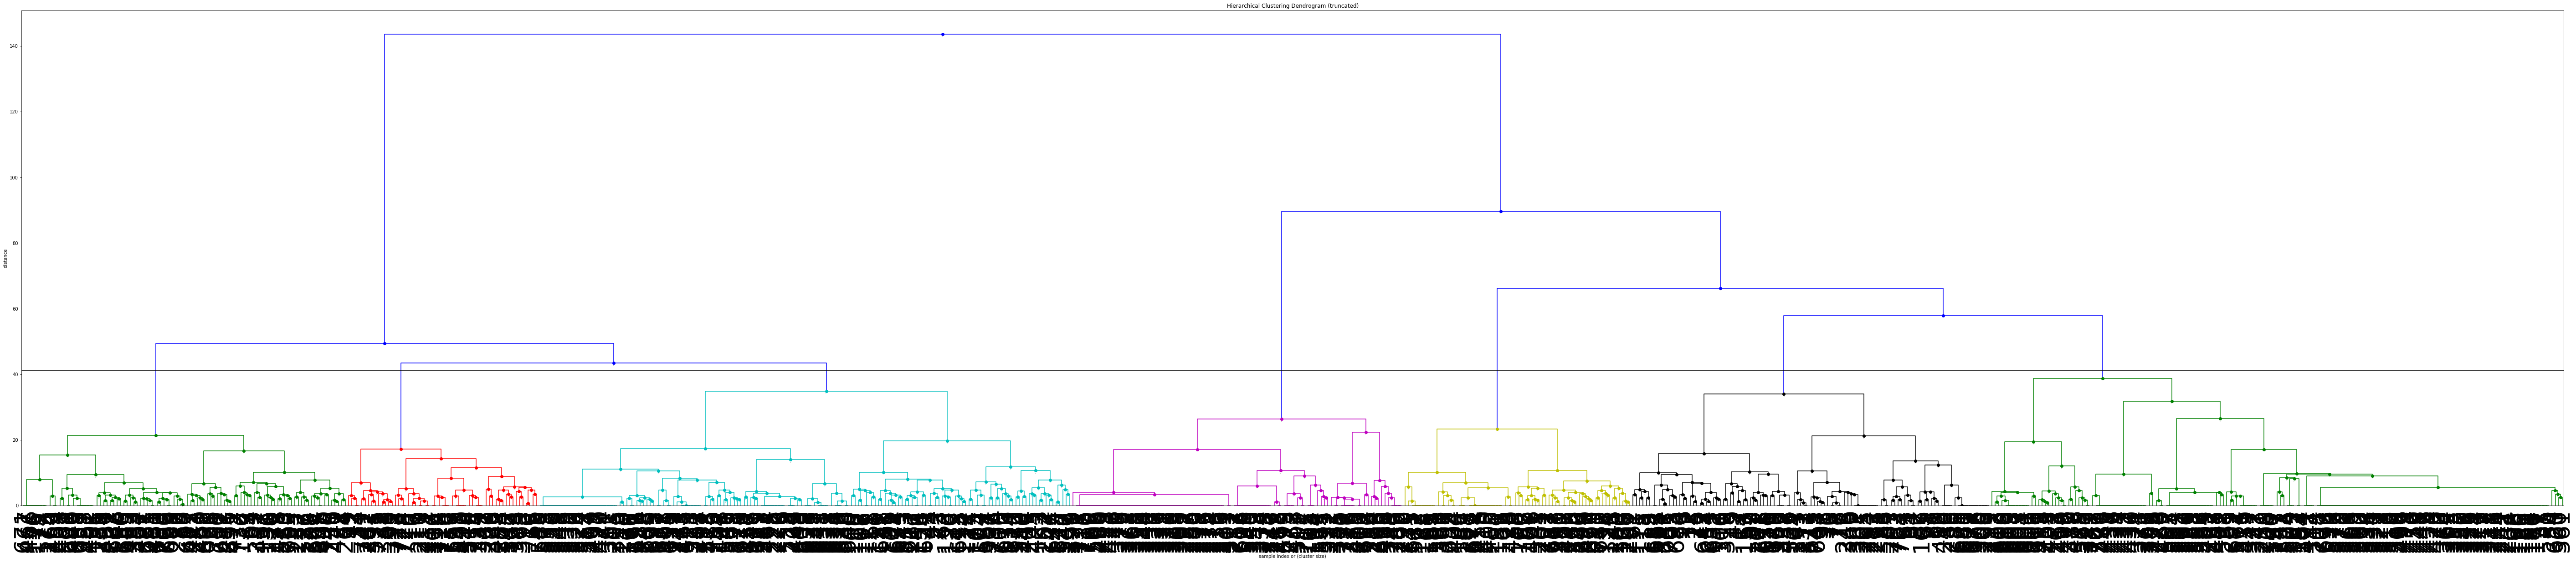

Found errors []
Purity: 5.06


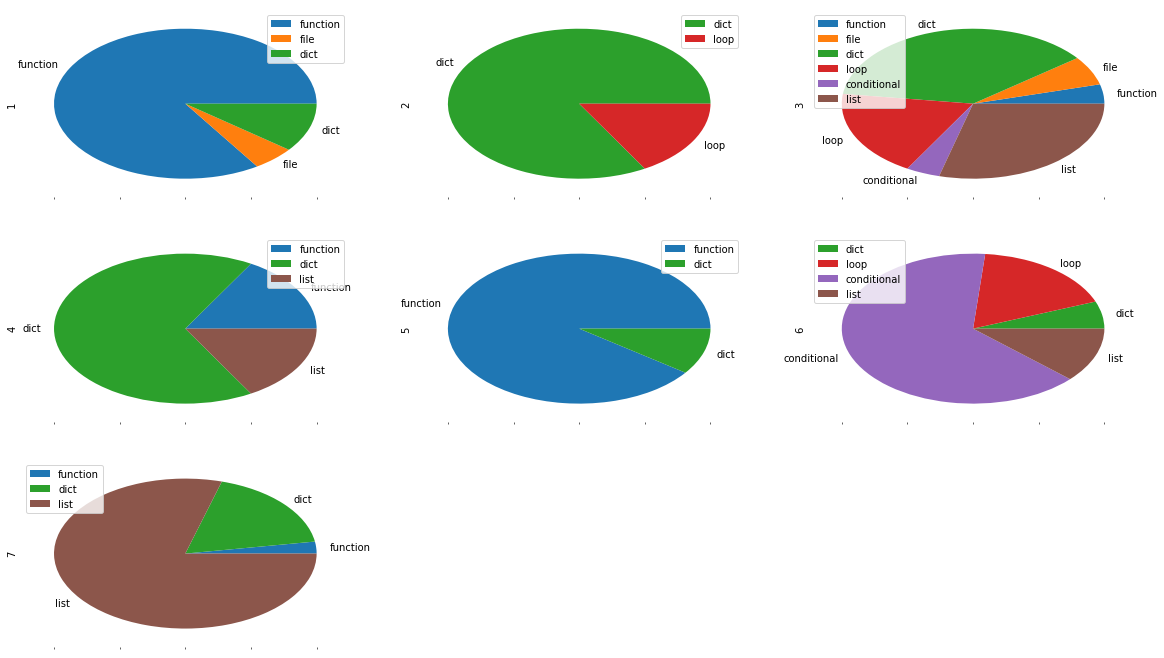

Using max_d = 36.80


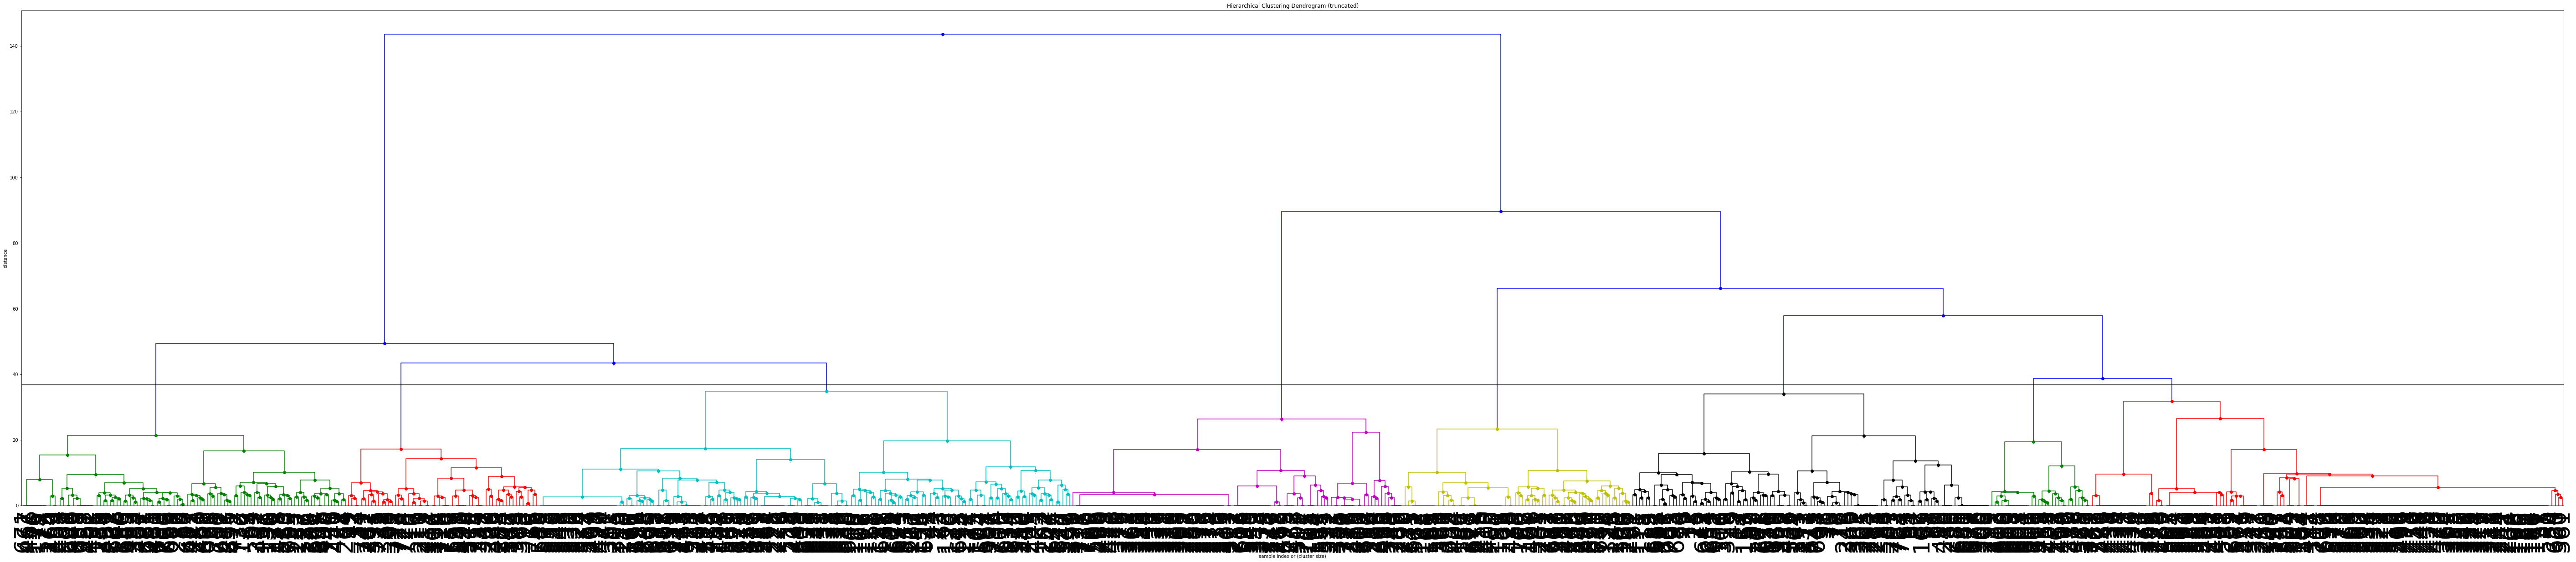

Found errors []
Purity: 6.05


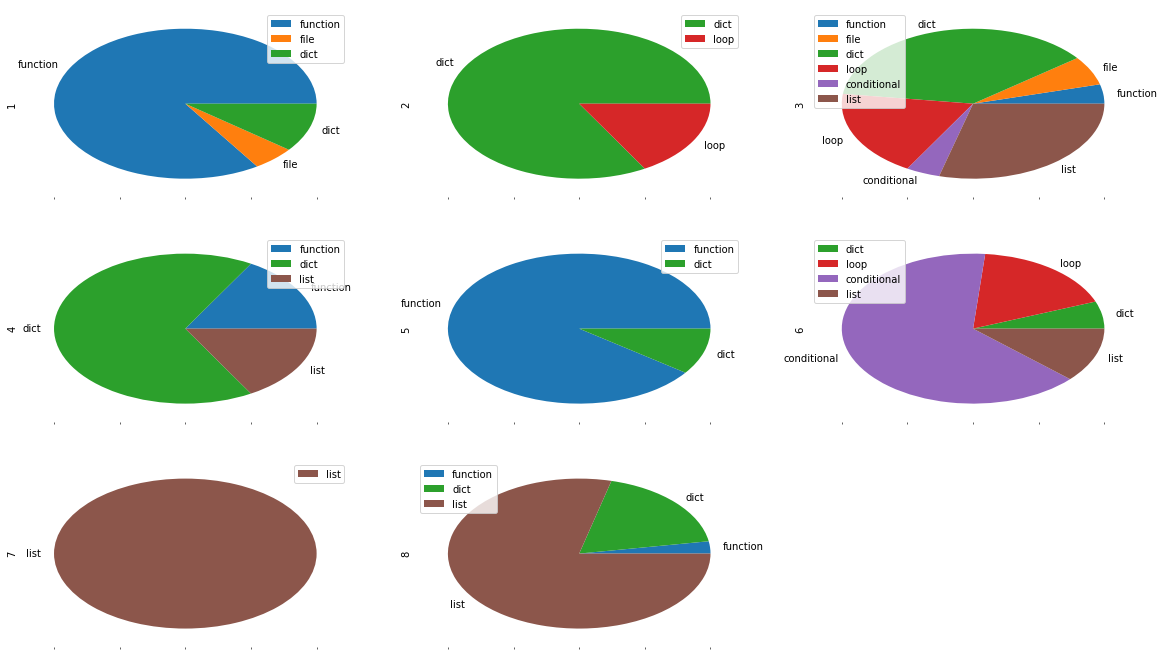

Using max_d = 34.41


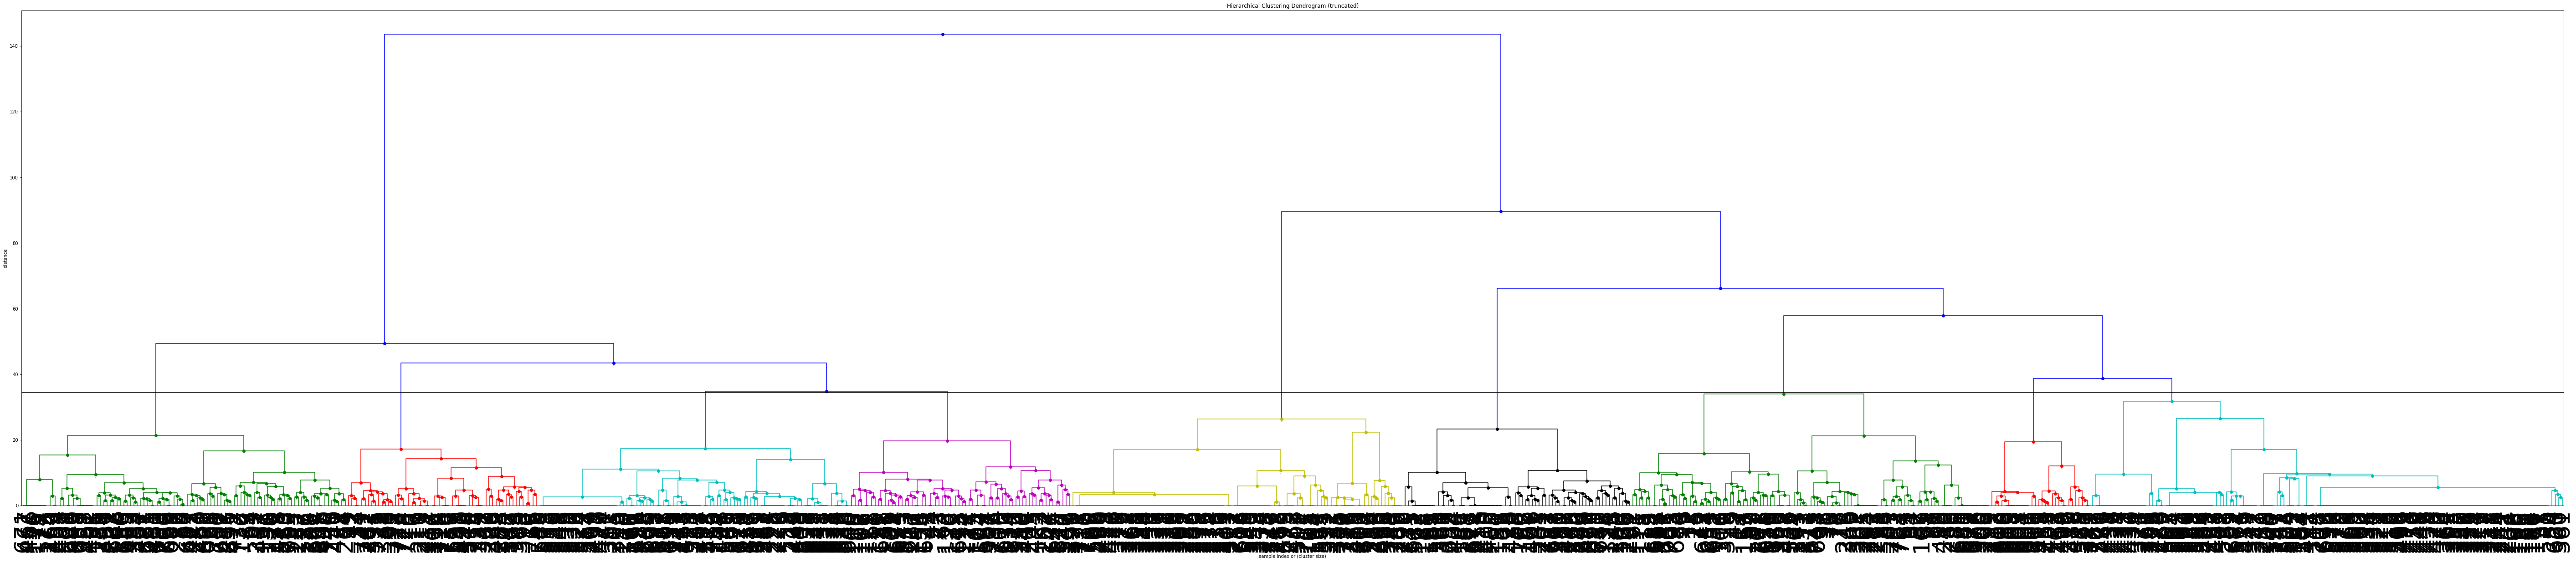

Found errors []
Purity: 6.65


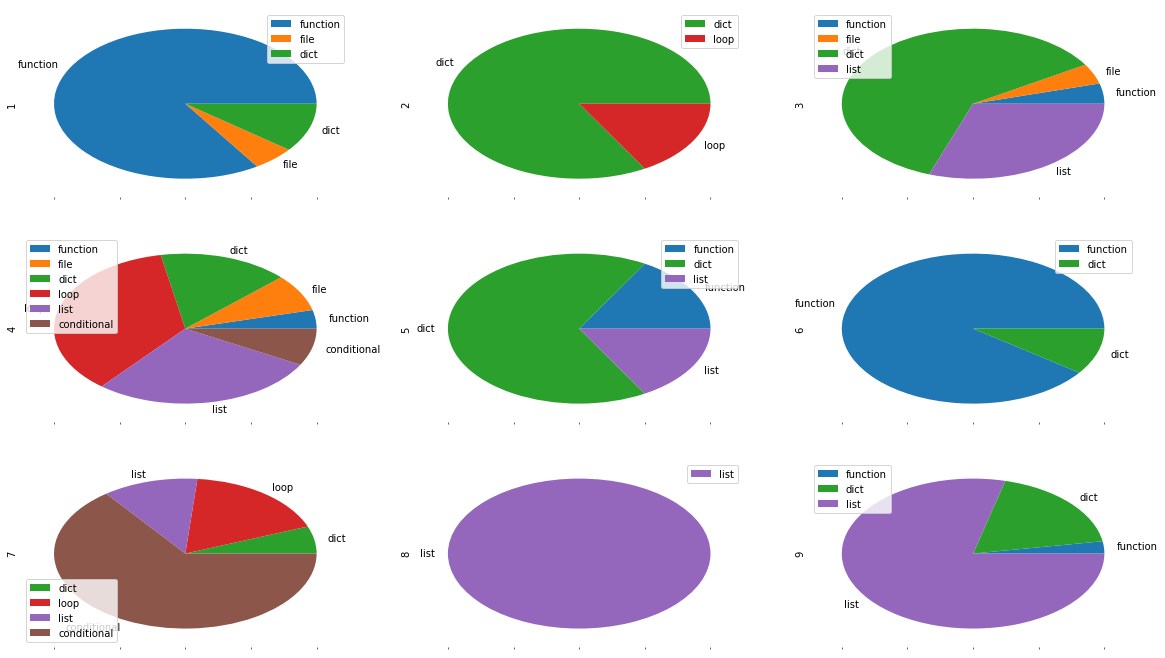

Using max_d = 32.89


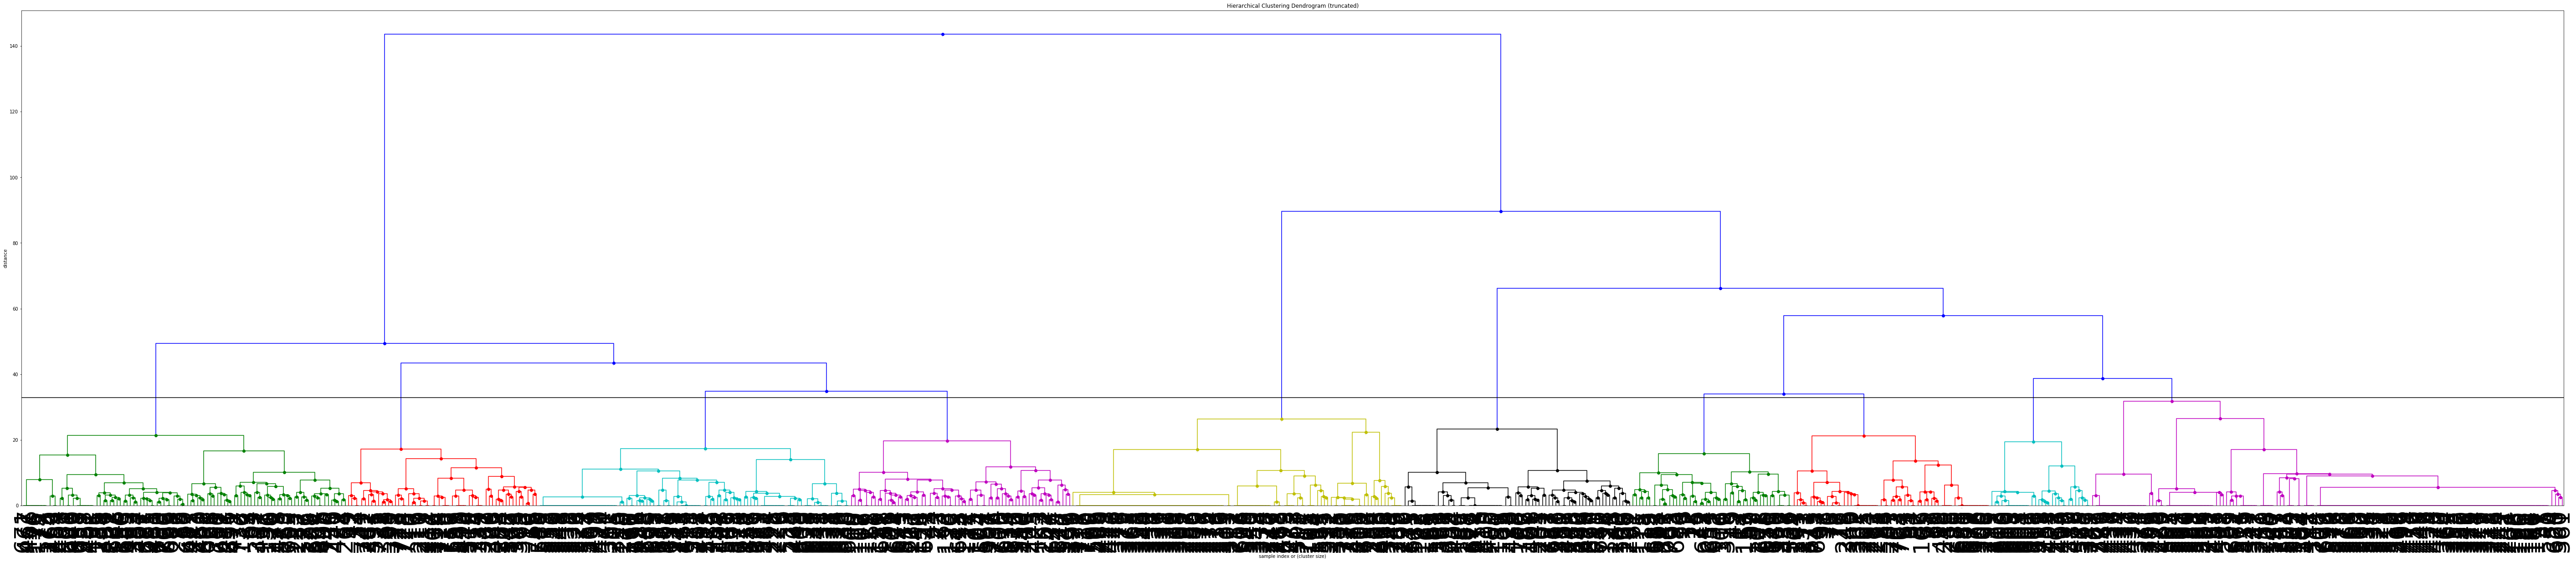

Found errors []
Purity: 7.37


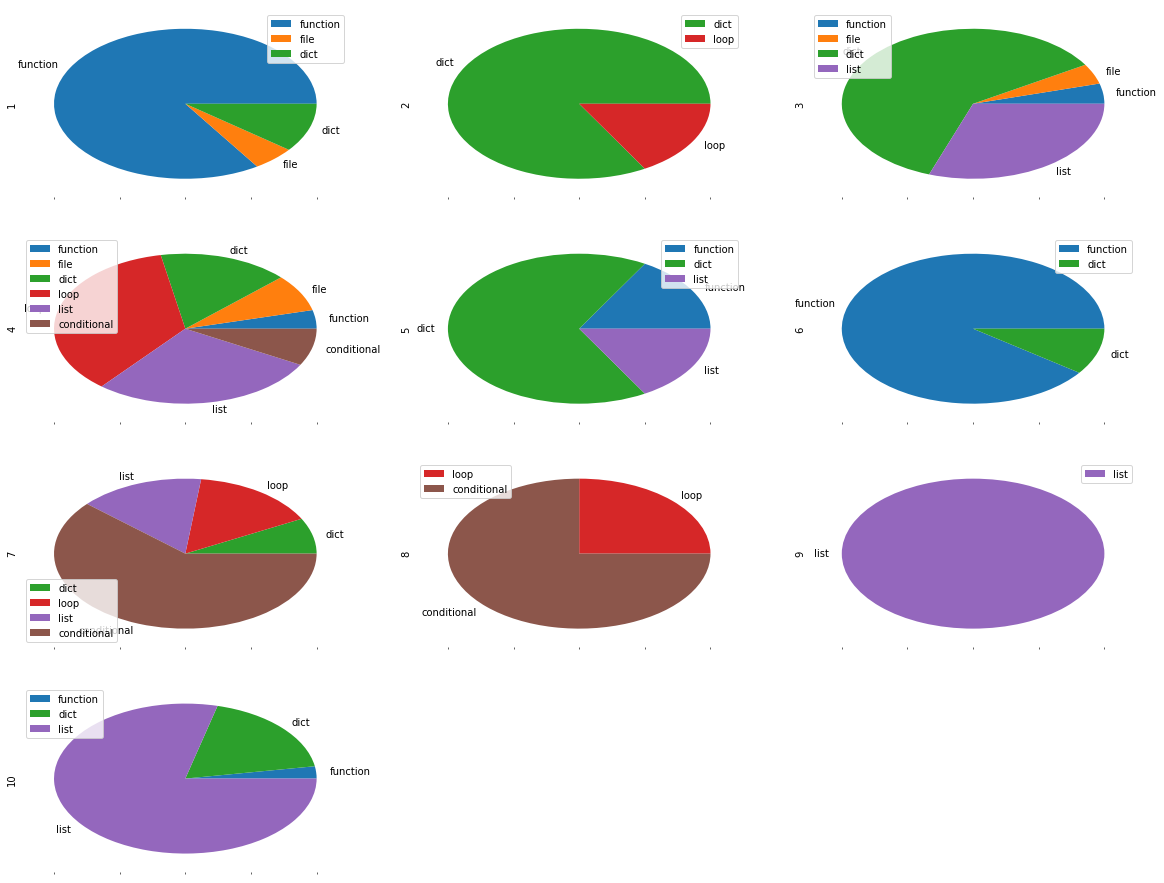

In [776]:
td = []
t_purity = []
for k in range(2,k_max+1):
    max_d = (distances[k-2] + distances[k-1])/2
    print("Using max_d = %.2f" % max_d)
    fig = plt.figure(figsize=(100, 20))
    ddata = fancy_dendrogram(
        Z,
    #     truncate_mode='lastp',
    #     p=10,
        leaf_rotation=90.,
        leaf_font_size=50.,
        show_contracted=True,
    #     annotate_above=10,  # useful in small plots so annotations don't overlap
        max_d=max_d,
        font_size=1.,
    )
    plt.savefig("dendogram_%d.png" % k)
    plt.show()
   
    # Get labeled documents per cluster
    clusters = hierarchy.fcluster(Z, k, criterion='maxclust')
        
    topics_dist = {}
    idx_error = []

    # Calculate category distribution over clusters
    for i in range(1, len(set(clusters))+1):
        obs_idx = np.where(clusters == i)
        topics_dist[i] = defaultdict(int)
        for doc in obs_idx[0]:
            category = doc_category[doc]
            topics_dist[i][category] += 1
    td.append(topics_dist)

    print("Found errors %s" % idx_error)
    topics_df = pd.DataFrame.from_dict(topics_dist)
    topic_df_nan = topics_df.drop([None, 'math', 'string'])
    topic_df_nan.plot.pie(figsize=(20,20), subplots=True, layout=(5, 3))
    plt.savefig("topics_%d.png" % k)
    
    # Calculate purity
    max_value = topic_df_nan.max()
    total_value = topic_df_nan.sum()
    purity = (max_value/total_value).sum()
    t_purity.append(purity)
    print("Purity: %.2f" % purity)
    
    plt.show()

In [21]:
def calculate_wk(X, y, distance='euclidean'):
    """ Calculate nr, dr and wk """
    min_k = np.array(y).min()
    max_k = np.array(y).max()
    wk = []
    
    for i in range(min_k, max_k+1):
        # Calculate Dr for each cluster
        obs_idx = np.where(y == i)[0]
        nr = obs_idx.shape[0]
#         
#         if nr == 0:
#             raise TypeError("There are empty clusters.")
        
        # Get pairwise distance
        dist = pdist(X[obs_idx], distance).sum()
        
        # Calculate Wk
        wki = dist/(2*nr)
        wk.append(wki)
    
    return np.array(wk).sum()

def get_clusters(X, k, mode='hierarquical', **kwargs):
    """ Different clustering modes. """
    if mode == 'hierarquical':
        # Create linkage matrix for original data
        Z = hierarchy.linkage(X, **kwargs)
        clusters = hierarchy.fcluster(Z, k, criterion='maxclust')    
    elif mode == 'kmeans':
        clusters = KMeans(n_clusters=k).fit_predict(X)
    elif mode == 'LDA':
        model = LatentDirichletAllocation(n_components=k, max_iter=10, learning_method='batch')
        document_topic = model.fit_transform(X)
        clusters = np.argmax(document_topic, axis=1)
    return clusters

In [14]:
def prepare_ref_dataset(data, nrefs=20):
    shape = data.shape
    # Set bounding box
    tops = data.max(axis=0)
    bots = data.min(axis=0)

    # Generate distribution
    rands = random.random_sample(size=(shape[0],shape[1],nrefs))

    # Set offset for random uniform samples to be inside bounding boxes
    dists = scipy.matrix(scipy.diag(tops-bots))
    for i in range(nrefs):
        rands[:,:,i] = rands[:,:,i]*dists+bots
        
    return rands

In [15]:
def calculate_gap(X, refs, k_max, mode='hierarquical'):
    gaps = []
    error = []
    
    for k in range(2,k_max+1):
        # Calculate Wk for original data
        clusters = get_clusters(X, k, mode, method='ward')
        wk = calculate_wk(X, clusters)
        log_wk = np.log(wk)

        # Calculate Wk for reference distribution
        wk_refs = []
        for ref in range(refs.shape[2]):
            clusters = get_clusters(refs[:,:,ref], k, mode, method='ward')
            wk_ref = calculate_wk(refs[:,:,ref], clusters)
            log_wk_ref = np.log(wk_ref)
            wk_refs.append(log_wk_ref)
        wkb = np.array(wk_refs)
        wkb_sum = wkb.sum()
        wkb_std = wkb.std()
        B = wkb.shape[0]

        # Calculate Gap
        gap_k = (1/B*wkb_sum) - log_wk
        gaps.append(gap_k)
        error.append(np.sqrt(wkb_std*(1+(1/B))))
    
    return gaps, error

def define_k(gaps, error):
    for i in range(2,k_max):
        k = i-2
        gapi = gaps[k]
        gapi1 = gaps[k+1]
        std = error[k+1]
        
        if gapi >= (gapi1-std):
            print("k = %d" % (k+2))
            break
            
    diff = np.array(gaps) - np.array(error)
    gaps[1:] = gaps[:-1]
    gap_diff = np.array(gaps) > diff
    k = np.argmax(gap_diff[1:] == True)
    print("k = %d" % (k+2))

In [30]:
import scipy
from scipy.spatial.distance import pdist

In [31]:
k_max = 26

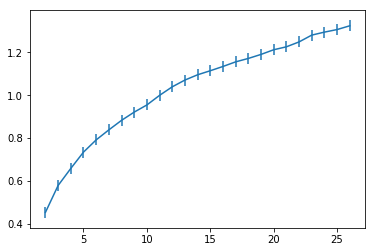

k = 13
k = 13


In [34]:
refs = prepare_ref_dataset(dist, nrefs=100)

# Calculate gaps and error
gaps, error = calculate_gap(dist, refs, k_max, 'hierarquical')

# Plot data
plt.errorbar(range(2,len(gaps)+2), gaps, yerr=error)
plt.show()

# Get best k
k = define_k(gaps, error)

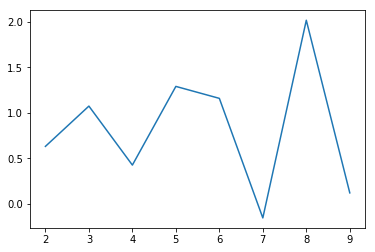

clusters: 8


In [806]:
# plt.plot(np.arange(2, len(t_purity)+2), t_purity)

acceleration = np.diff(t_purity, 1)  # 2nd derivative of the distances
plt.plot(np.arange(2, len(t_purity)+1), acceleration)
plt.show()
k = acceleration.argmax()
print("clusters:", k+2)

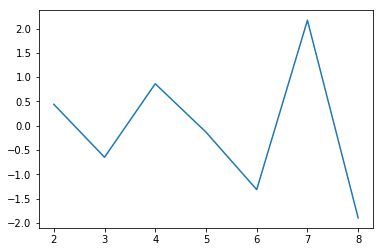

clusters: 7


In [807]:
t_purity
acceleration = np.diff(t_purity, 2)  # 2nd derivative of the distances
plt.plot(np.arange(2, len(t_purity)), acceleration)
plt.show()
k = acceleration.argmax()
print("clusters:", k+2)

In [791]:
acceleration

array([ 0.29484127, -0.13664081,  0.07292053, -0.14315803,  0.21219448,
       -0.40090624,  0.12463014])

In [ ]:
from sklearn.manifold import MDS

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

In [227]:
from sklearn.manifold import TSNE

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = TSNE(n_components=2, metric='cosine', random_state=1)

pos = mds.fit_transform(train_data_features)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

In [228]:
pos.shape

(758, 2)

In [283]:
cluster_names = ['', 'conditional', 'dict', 'file', 'function', 'list', 'loop'] #'math', 'string']
cluster_colors = {}
for i in range(7):
    color = cm.tab10(i / 7)
    color_hex = mpl_colors.rgb2hex(color[:3])
    cluster_colors[cluster_names[i]] = color_hex

In [284]:
import matplotlib as mpl

In [285]:
def make_ellipses(gmm, ax):
    for n, color in enumerate(colors):
        if gmm.covariance_type == 'full':
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == 'tied':
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == 'diag':
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == 'spherical':
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                                  180 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)

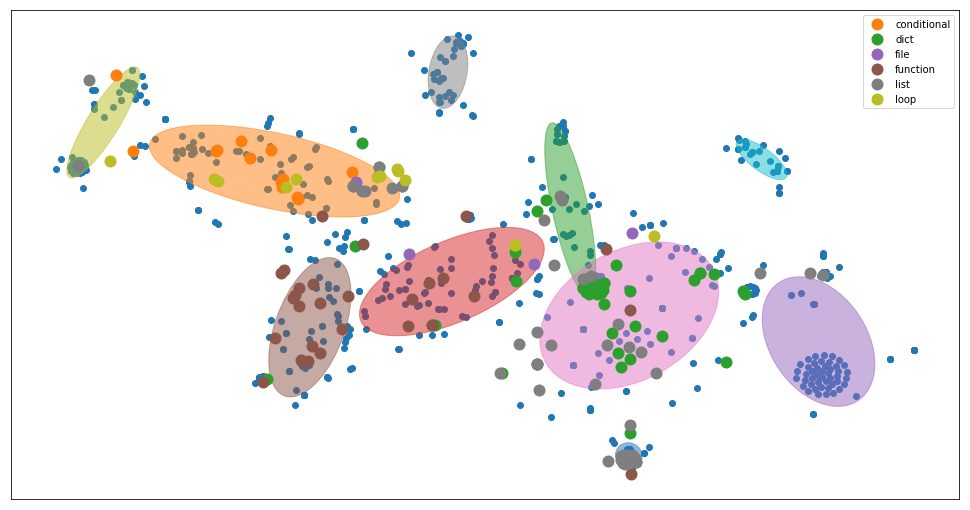

In [291]:

#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=doc_category, title=doc_id)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    if name == 'math' or name == 'string':
        continue
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=name, color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

N = 10
colors = []
for i in range(N):
    color = cm.tab10(i / N)

    color_hex = mpl_colors.rgb2hex(color[:3])
    colors.append(color_hex)

plt.scatter(xs,ys)
make_ellipses(models[N]['model'], ax)

#add label in x,y position with the label as the film title
# for i in range(len(df)):
#     ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=8)  

    
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)

In [710]:
dist.shape

(758, 758)

In [713]:
from scipy.cluster.hierarchy import ward, dendrogram

Z = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

In [718]:
for opt in ['ward', 'single', 'complete', 'average', 'weighted', 'centroid', 'median']:
    Z = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances
    c, coph_dists = cophenet(Z, dist)
    print("%s = %.4f" % (opt, c))

ValueError: Condensed distance matrix 'Y' must have shape=1 (i.e. be one-dimensional).

In [17]:
def print_top_words(topic_word, feature_names, n_top_words):
    for topic_idx, topic in enumerate(topic_word):
        message = "Topic #%d: " % (topic_idx+1)
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [18]:
print("\nTopics in LDA model:")
feature_names = vectorizer.get_feature_names()
print_top_words(topic_word, feature_names, 5)


Topics in LDA model:
Topic #1: def return if else while
Topic #2: str len append import if
Topic #3: join raw_input int and in
Topic #4: import float from input append
Topic #5: if true false len else
Topic #6: format input import len int
Topic #7: list def while range len
Topic #8: int elif input if else
Topic #9: random set import range in
Topic #10: in for range if append



### Cálculo da Silhueta ###

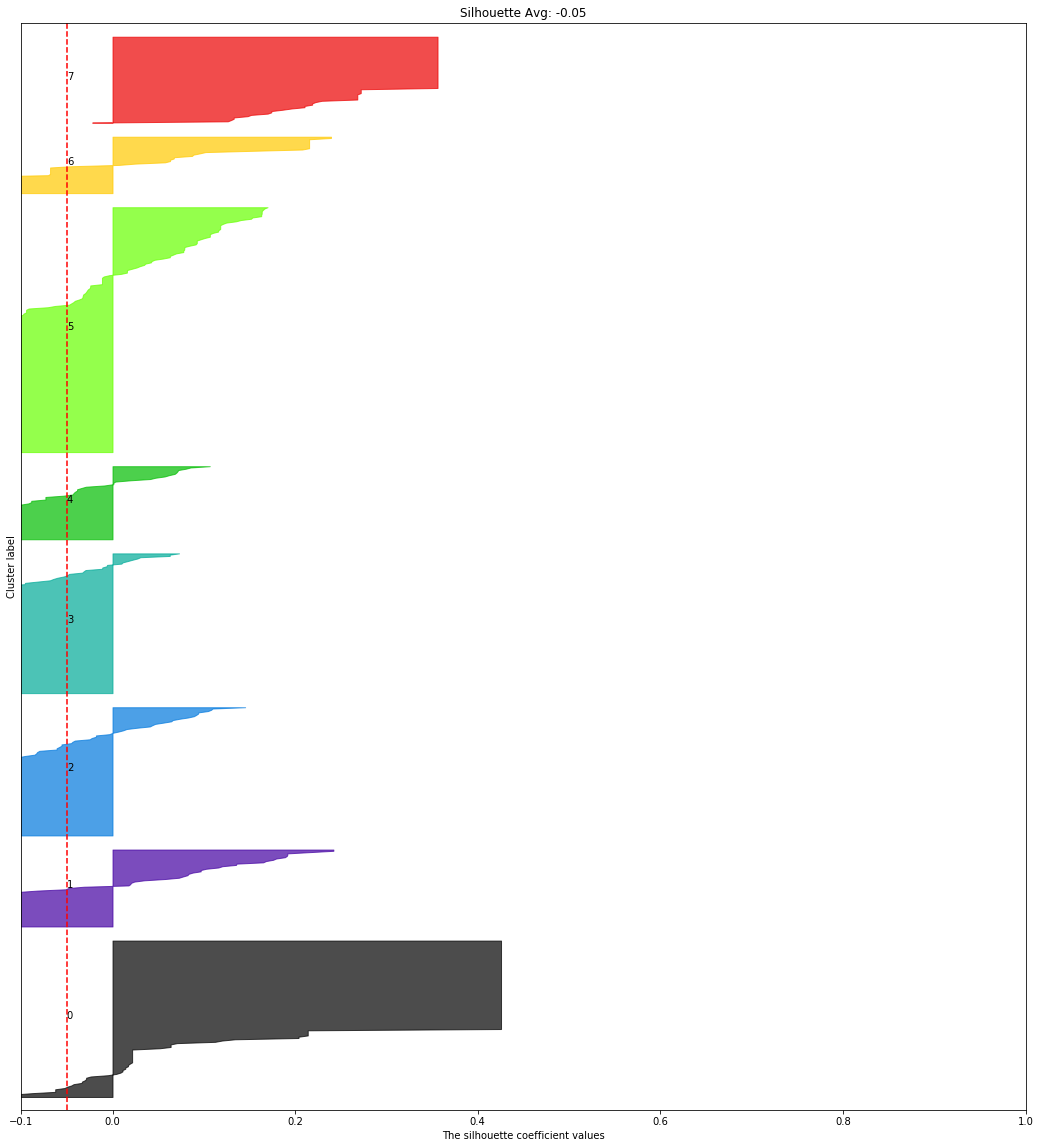

In [745]:
num_topics_sil = range(2, 10)
#num_topics_sil = [50]
num_topics_sil = [8]
for k in num_topics_sil:
# Compatibility
    X = train_data_features
    n_clusters = k
    cluster_labels = np.argmax(models[k]['document_topic'], axis=1)
    silhouette_avg = models[k]['silhouette']
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(18, 20)
#     fig.set_size_inches(18, 10)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, X.shape[0] + (n_clusters + 1) * 10])
    
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
        
    ax1.set_title("Silhouette Avg: %.2f" % silhouette_avg)
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.show()

# Dúvidas #
1. Qual vectorizer? Com TF-IDF? Número mínimo de frequencia de palavras?
2. Qual métrica para escolher um cluster? Perplexity? Sillhouete? Coerência?
3. Quantos clusters?
4. Outras maneiras de clusterização? Hierárquico?

# Referências #
2. [Blei, David M., Andrew Y. Ng, and Michael I. Jordan. "Latent dirichlet allocation." Journal of machine Learning research 3.Jan (2003): 993-1022.](https://web.stanford.edu/class/linguist289/lda.pdf)
1. [Quora - What is a good explanation of Latent Dirichlet Allocation?](https://www.quora.com/What-is-a-good-explanation-of-Latent-Dirichlet-Allocation)
2. [Experiments with Latent Dirichlet Allocation](https://mollermara.com/blog/lda/)
3. [Scikit-Learn - Latent Dirichlet Allocation](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html)